# differences in meteorological variables

This notebook is for plotting:

- **Figure 1**: Changes in the LENTIS present-day and future ensemble means for mean climate variables relevant for renewable electricity production and demand.
- **Supplementary Figure 1**: Changes in the LENTIS present-day and future ensemble RSD for mean climate variables relevant for renewable electricity production and demand.
- **Supplementary Figure 2**: Changes in the LENTIS present-day and future ensemble means for mean hydrological variables to explain runoff.
- **Supplementary Figure 3**: Changes in the LENTIS present-day and future ensemble means for RSD hydrological variables to explain runoff.


# means 
## variables for energy model

<ipython-input-1-91fac892eb62>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


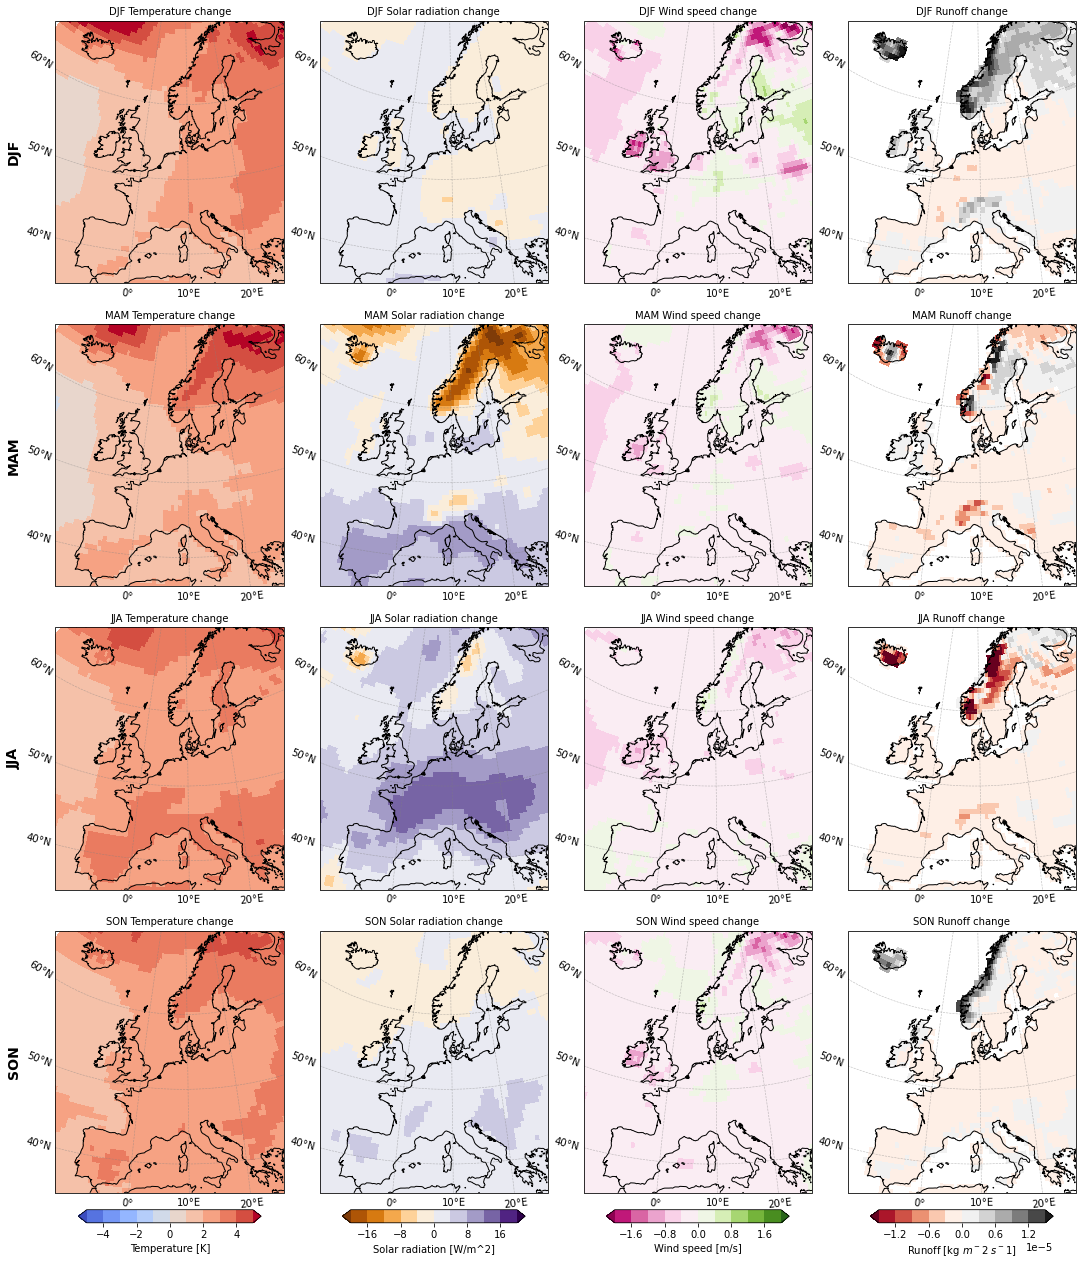

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Define the variables and their respective file paths
variables = ['tas', 'rsds', 'sfcWind', 'mrro']#['pet', 'pr', 'snm']
base_path = # path the climate data 
present_path = 'present/day/{var}_d/processed/climatology_mean.nc'
future_path = 'future/day/{var}_d/processed/climatology_mean.nc'


# Define units for the variables for better colorbar labeling
varunits = {
    'tas': 'Temperature [K]',
    'sfcWind': 'Wind speed [m/s]',
    'mrro': r'Runoff [kg $m^-2$ $s^-1$]',
    'rsds': 'Solar radiation [W/m^2]',
    'pr': 'Precipitation [kg $m^-2$ $s^-1$]',
    'pet': 'Potential evapotranspiration [mm/day]',
    'snm': 'Snow melt [kg $m^-2$ $s^-1$]'
    
}

varnames = {
    'tas': 'Temperature',
    'sfcWind': 'Wind speed',
    'mrro': 'Runoff',
    'rsds': 'Solar radiation',
    'pr': 'Precipitation',
    'pet': 'Evapotranspiration',
    'snm': 'Snow melt'
}

# Define the size and layout of the figure with the specified projection
fig, axs = plt.subplots(4, 4, figsize=(15, 17), subplot_kw=dict(projection=ccrs.EuroPP()))

# Define colors
cmaps = ['coolwarm','PuOr',  'PiYG', 'RdGy', 'RdGy',  'RdGy','RdGy']

# Set consistent color ranges for the colorbars
vmin_vmax = {
    'tas': (-5, 5),  # Adjust according to the expected range of differences
    'sfcWind': (-2, 2),
    'mrro': (-1.5e-5, 1.5e-5),
    'rsds': (-20, 20),
    'pr':  (-1.8e-5, 1.8e-5),
    'pet':  (-0.5, 0.5),
    'snm':  (-1.5e-5, 1.5e-5)
}

# Define season labels
season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# Function to plot data on the axes
def plot_diff(data, ax, var, title, cmap, levels, vmin, vmax, units, add_colorbar=False):
    
    im = data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels,
                   transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    ax.set_title(title, fontsize=10)
    ax.coastlines()
    
    # Add the colorbar only if add_colorbar is True
    if add_colorbar:
        # Create an inset axis for the colorbar
        cax = inset_axes(ax, width="80%", height="5%", loc='lower center', borderpad=-3)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(units, fontsize=10)
        
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlocator = FixedLocator([0, 10, 20])
    gl.ylocator = FixedLocator([40, 50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Loop through each variable to load data, compute differences, and plot
for i, var in enumerate(variables):
    file1 = f'{base_path}/{present_path.format(var=var)}'
    file2 = f'{base_path}/{future_path.format(var=var)}'

    if var == 'snm':
            file1 = file1.replace('_d', '_m').replace('day', 'month')
            file2 = file2.replace('_d', '_m').replace('day', 'month')
    dspd = xr.open_dataset(file1).load()
    dsfu = xr.open_dataset(file2).load()

    # Define seasons
    seasons = {
        'DJF': [12, 1, 2],   # Winter
        'MAM': [3, 4, 5],    # Spring
        'JJA': [6, 7, 8],    # Summer
        'SON': [9, 10, 11]   # Autumn
    }

    # Define levels for this variable
    levels = np.linspace(vmin_vmax[var][0], vmin_vmax[var][1], 11)  # 10 intervals (5 positive, 5 negative)

    # Select data for each season and calculate the difference
    seasonal_diffs = {}
    for season, months in seasons.items():
        dspd_season = dspd[var].sel(time=dspd.time.dt.month.isin(months)).mean(dim='time')
        dsfu_season = dsfu[var].sel(time=dsfu.time.dt.month.isin(months)).mean(dim='time')
        seasonal_diffs[season] = dsfu_season - dspd_season

    # Plot the seasonal differences
    for j, season in enumerate(seasons.keys()):
        add_colorbar = (j == 3)  # Only add colorbar on the last row
        plot_diff(seasonal_diffs[season], axs[j, i], var, f'{season} {varnames[var]} change', 
                  cmaps[i], levels, vmin_vmax[var][0], vmin_vmax[var][1], varunits[var], add_colorbar=add_colorbar)

        # Add season labels on the left side of each row, rotated to be parallel to the x-axis
        if i == 0:
            axs[j, 0].text(-0.15, 0.5, season_labels[j], va='center', ha='right', 
                           transform=axs[j, 0].transAxes, fontsize=14, fontweight='bold', rotation=90)

# Adjust layout
plt.tight_layout()

# Save the figure as a high-resolution PNG
plt.savefig('figure1_1.png', dpi=300, bbox_inches='tight')

plt.show()


## monthly means runoff evapotranpo 

<ipython-input-2-311025d55795>:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


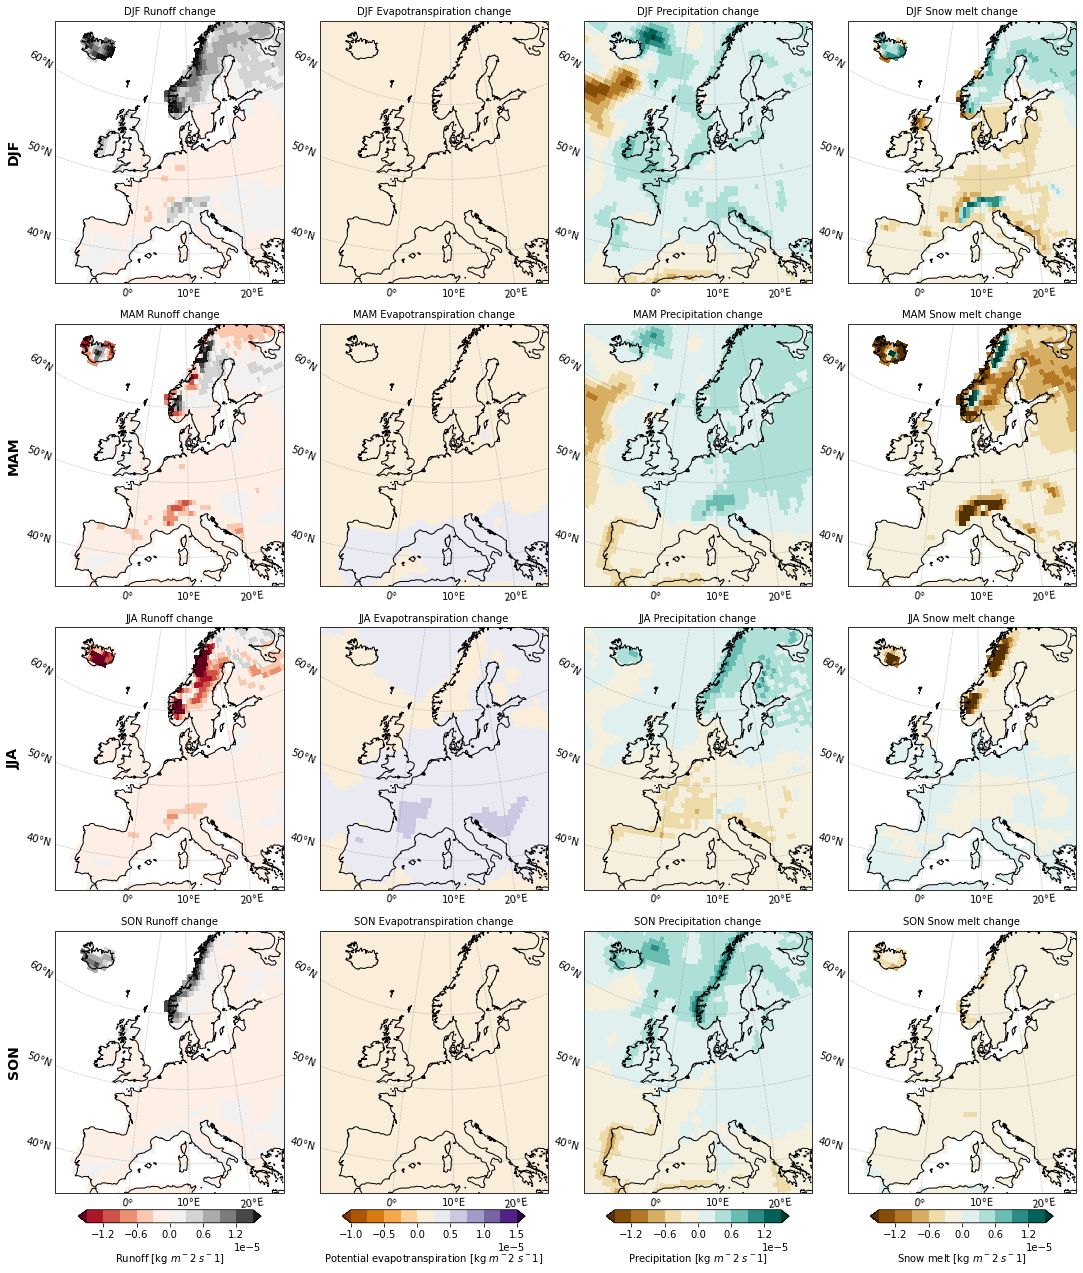

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Define the variables and their respective file paths
variables = [ 'mrro','pet', 'pr', 'snm']
base_path = # path to climate data 
present_path = 'present/month/{var}_m/processed/climatology_mean.nc'
future_path = 'future/month/{var}_m/processed/climatology_mean.nc'


# Define units for the variables for better colorbar labeling
varunits = {
    'tas': 'Temperature [K]',
    'sfcWind': 'Wind speed [m/s]',
    'mrro': r'Runoff [kg $m^-2$ $s^-1$]',
    'rsds': 'Solar radiation [W/m^2]',
    'pr': 'Precipitation [kg $m^-2$ $s^-1$]',
    'pet': 'Potential evapotranspiration [kg $m^-2$ $s^-1$]',
    'snm': 'Snow melt [kg $m^-2$ $s^-1$]'
    
}

varnames = {
    'tas': 'Temperature',
    'sfcWind': 'Wind speed',
    'mrro': 'Runoff',
    'rsds': 'Solar radiation',
    'pr': 'Precipitation',
    'pet': 'Evapotranspiration',
    'snm': 'Snow melt'
}

def convert_mmday_kgm2s(da_pet):
    conversion_factor = 1.1574074074e-5  # This is 0.001/86400 * 1000
    da_pet = da_pet * conversion_factor

    # Update the units attribute to kg/m²/s
    da_pet.attrs['units'] = 'kg m-2 s-1'
    return da_pet

# Define the size and layout of the figure with the specified projection
fig, axs = plt.subplots(4, 4, figsize=(15, 17), subplot_kw=dict(projection=ccrs.EuroPP()))

# Define colors
cmaps = ['RdGy', 'PuOr', 'BrBG','BrBG']#['coolwarm', 'PiYG', 'PuOr', 'RdGy', 'RdGy',  'RdGy','RdGy']

# Set consistent color ranges for the colorbars
vmin_vmax = {
    'tas': (-5, 5),  # Adjust according to the expected range of differences
    'sfcWind': (-2, 2),
    'mrro': (-1.5e-5, 1.5e-5),
    'rsds': (-20, 20),
    'pr':  (-1.5e-5, 1.5e-5),
    'pet':  (-1e-5, 1.5e-5),
    'snm':  (-1.5e-5, 1.5e-5)
}

# Define season labels
season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# Function to plot data on the axes
def plot_diff(data, ax, var, title, cmap, levels, vmin, vmax, units, add_colorbar=False):
    im = data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels,
                   transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    ax.set_title(title, fontsize=10)
    ax.coastlines()
    
    # Add the colorbar only if add_colorbar is True
    if add_colorbar:
        # Create an inset axis for the colorbar
        cax = inset_axes(ax, width="80%", height="5%", loc='lower center', borderpad=-3)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(units, fontsize=10, labelpad=12)

        
        
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlocator = FixedLocator([0, 10, 20])
    gl.ylocator = FixedLocator([40, 50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Loop through each variable to load data, compute differences, and plot
for i, var in enumerate(variables):
    file1 = f'{base_path}/{present_path.format(var=var)}'
    file2 = f'{base_path}/{future_path.format(var=var)}'

    dspd = xr.open_dataset(file1).load()
    dsfu = xr.open_dataset(file2).load()

    # Define seasons
    seasons = {
        'DJF': [12, 1, 2],   # Winter
        'MAM': [3, 4, 5],    # Spring
        'JJA': [6, 7, 8],    # Summer
        'SON': [9, 10, 11]   # Autumn
    }

    # Define levels for this variable
    levels = np.linspace(vmin_vmax[var][0], vmin_vmax[var][1], 11)  # 10 intervals (5 positive, 5 negative)

    # Select data for each season and calculate the difference
    seasonal_diffs = {}
    for season, months in seasons.items():
        dspd_season = dspd[var].sel(time=dspd.time.dt.month.isin(months)).mean(dim='time')
        dsfu_season = dsfu[var].sel(time=dsfu.time.dt.month.isin(months)).mean(dim='time')
        seasonal_diffs[season] = dsfu_season - dspd_season
        
        # change unit
        if var == 'pet':
            seasonal_diffs[season] = convert_mmday_kgm2s(seasonal_diffs[season])
    # Plot the seasonal differences
    for j, season in enumerate(seasons.keys()):
        add_colorbar = (j == 3)  # Only add colorbar on the last row
        plot_diff(seasonal_diffs[season], axs[j, i], var, f'{season} {varnames[var]} change', 
                  cmaps[i], levels, vmin_vmax[var][0], vmin_vmax[var][1], varunits[var], add_colorbar=add_colorbar)

        # Add season labels on the left side of each row, rotated to be parallel to the x-axis
        if i == 0:
            axs[j, 0].text(-0.15, 0.5, season_labels[j], va='center', ha='right', 
                           transform=axs[j, 0].transAxes, fontsize=14, fontweight='bold', rotation=90)

# Adjust layout
plt.tight_layout()

# Save the figure as a high-resolution PNG
plt.savefig('subfig1_1.png', dpi=300, bbox_inches='tight')

plt.show()


# Relative Standard Deviation (RSD)

<ipython-input-2-fea1e7acc626>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


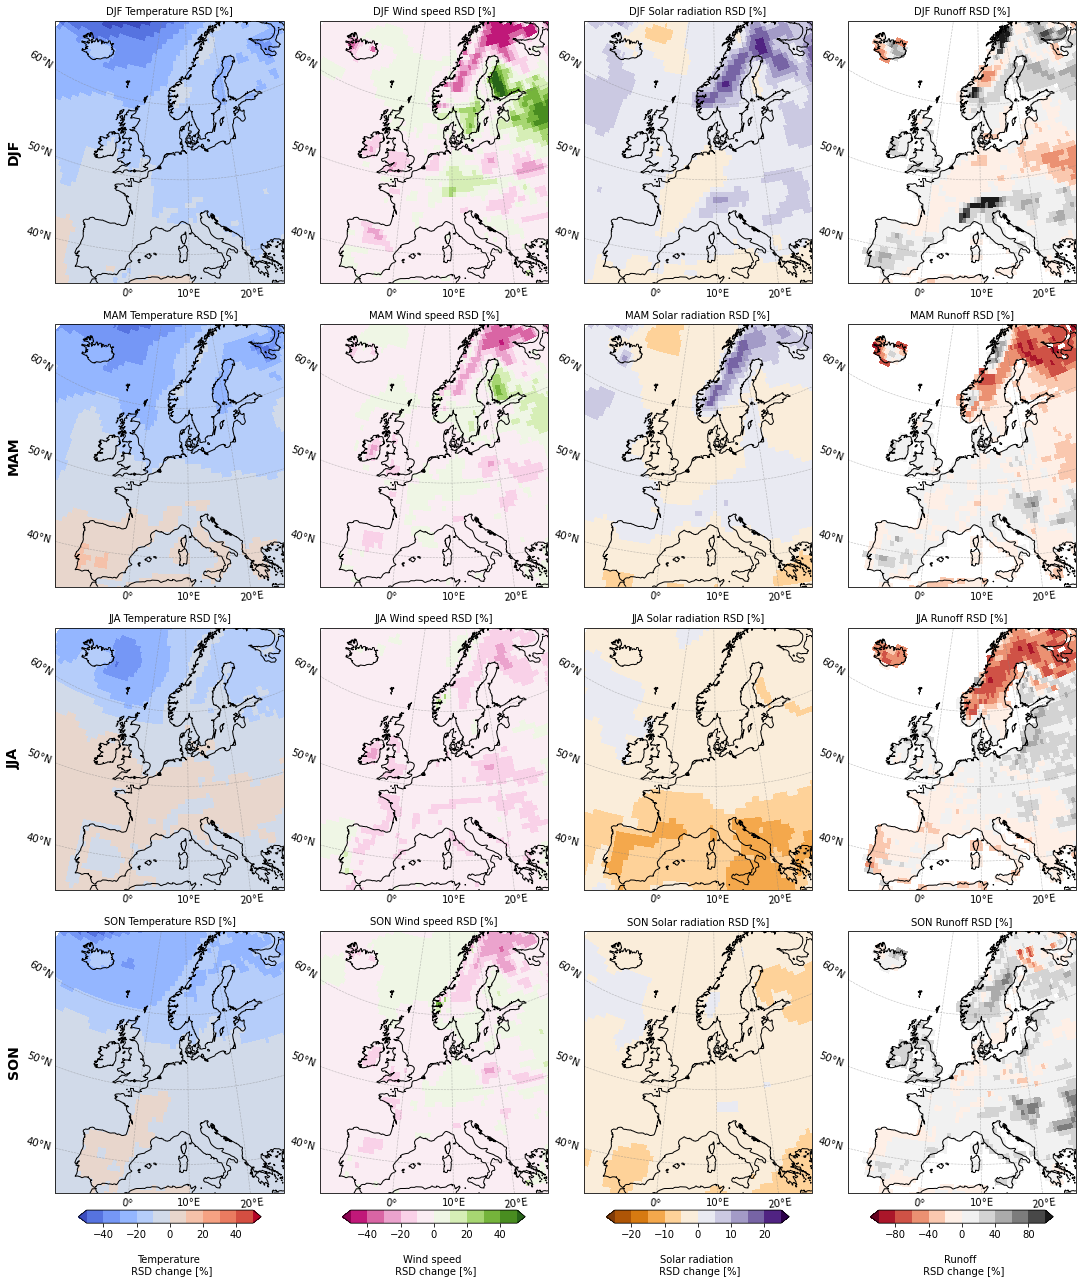

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define the variables and their respective file paths
variables = ['tas', 'sfcWind', 'rsds', 'mrro']
base_path = #path to climate data
present_path = 'present/day/{var}_d/processed/daily_ensemble_variability.nc'
future_path = 'future/day/{var}_d/processed/daily_ensemble_variability.nc'

# Define units for the variables for better colorbar labeling
varunits = {
    'tas': f'Temperature \n RSD change [%]',
    'sfcWind': 'Wind speed \n RSD change [%]',
    'mrro': 'Runoff \n RSD change [%]',
    'rsds': 'Solar radiation \n RSD change [%]'
}

varnames = {
    'tas': 'Temperature',
    'sfcWind': 'Wind speed',
    'mrro': 'Runoff',
    'rsds': 'Solar radiation'
}

# Define the size and layout of the figure with the specified projection
fig, axs = plt.subplots(4, 4, figsize=(15, 17), subplot_kw=dict(projection=ccrs.EuroPP()))

# Define colors
cmaps = ['coolwarm', 'PiYG', 'PuOr', 'RdGy']

# Set consistent color ranges for the colorbars
vmin_vmax = {
    'tas': (-50, 50),  # Adjust according to the expected range of RSD values
    'sfcWind': (-50, 50),
    'mrro': (-100, 100),
    'rsds': (-25, 25)
}

# Define season labels
season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# Function to plot data on the axes
def plot_diff(data, ax, var, title, cmap, levels, vmin, vmax, units, add_colorbar=False):
    im = data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels,
                   transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    ax.set_title(title, fontsize=10)
    ax.coastlines()
    
    # Add the colorbar only if add_colorbar is True
    if add_colorbar:
        # Create an inset axis for the colorbar
        cax = inset_axes(ax, width="80%", height="5%", loc='lower center', borderpad=-3)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(units, fontsize=10, labelpad=15)
        
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlocator = FixedLocator([0, 10, 20])
    gl.ylocator = FixedLocator([40, 50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Loop through each variable to load data, compute RSDs, and plot
for i, var in enumerate(variables):
    file1 = f'{base_path}/{present_path.format(var=var)}'
    file2 = f'{base_path}/{future_path.format(var=var)}'

    dspd = xr.open_dataset(file1).load()[[var]]
    dsfu = xr.open_dataset(file2).load()[[var]]

    # Define seasons
    seasons = {
        'DJF': [12, 1, 2],   # Winter
        'MAM': [3, 4, 5],    # Spring
        'JJA': [6, 7, 8],    # Summer
        'SON': [9, 10, 11]   # Autumn
    }

    # Define levels for this variable
    levels = np.linspace(vmin_vmax[var][0], vmin_vmax[var][1], 11)  # 10 intervals (5 positive, 5 negative)

    # Calculate RSD for each season
    seasonal_diffs = {}
    for season, months in seasons.items():
        dspd_season = dspd[var].sel(time=dspd.time.dt.month.isin(months)).mean(dim='time')
        dsfu_season = dsfu[var].sel(time=dsfu.time.dt.month.isin(months)).mean(dim='time')
        
        # Calculate the RSD
        rsd_season = 100 * (dsfu_season - dspd_season) / dspd_season
        seasonal_diffs[season] = rsd_season

    # Plot the seasonal differences (RSD)
    for j, season in enumerate(seasons.keys()):
        add_colorbar = (j == 3)  # Only add colorbar on the last row
        plot_diff(seasonal_diffs[season], axs[j, i], var, f'{season} {varnames[var]} RSD [%]', 
                  cmaps[i], levels, vmin_vmax[var][0], vmin_vmax[var][1], varunits[var], add_colorbar=add_colorbar)

        # Add season labels on the left side of each row, rotated to be parallel to the x-axis
        if i == 0:
            axs[j, 0].text(-0.15, 0.5, season_labels[j], va='center', ha='right', 
                           transform=axs[j, 0].transAxes, fontsize=14, fontweight='bold', rotation=90)

# Adjust layout
plt.tight_layout()



plt.savefig('figure1_2.png', dpi=300, bbox_inches='tight')

plt.show()

<ipython-input-4-2f1e344a6648>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


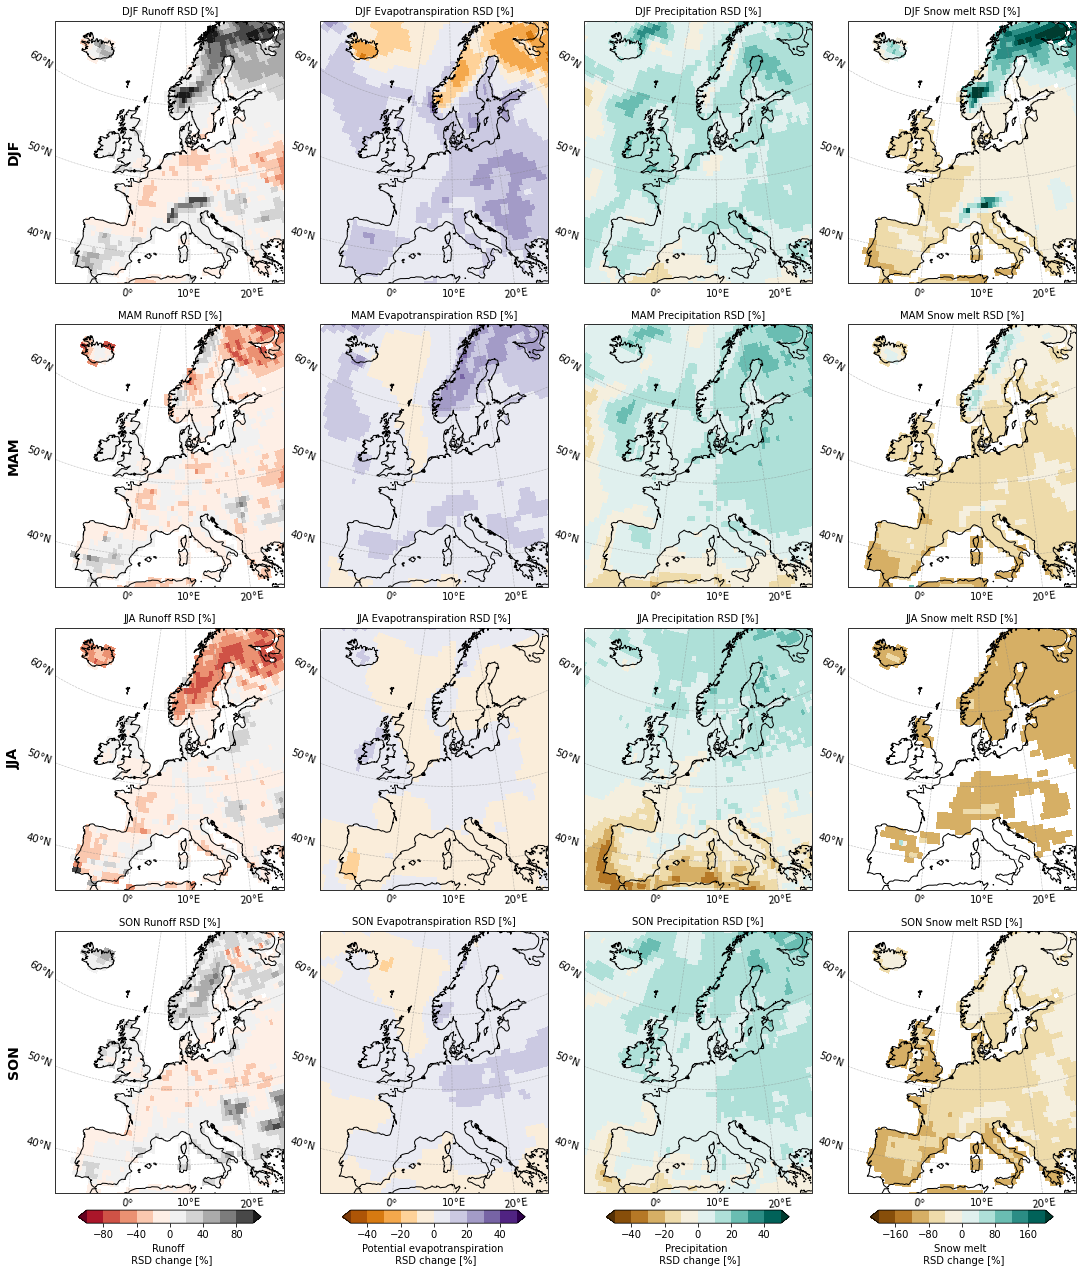

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define the variables and their respective file paths
variables = [ 'mrro','pet', 'pr', 'snm']
base_path = # path to climate data
present_path = 'present/month/{var}_m/processed/daily_ensemble_variability.nc'
future_path = 'future/month/{var}_m/processed/daily_ensemble_variability.nc'

# Define units for the variables for better colorbar labeling
varunits = {
    'mrro': f'Runoff \n RSD change [%]',
    'pr': f'Precipitation \n RSD change [%]',
    'pet': f'Potential evapotranspiration \n RSD change [%]',
    'snm': f'Snow melt \n RSD change [%]'
    
}

varnames = {
    'tas': 'Temperature',
    'sfcWind': 'Wind speed',
    'mrro': 'Runoff',
    'rsds': 'Solar radiation',
    'pr': 'Precipitation',
    'pet': 'Evapotranspiration',
    'snm': 'Snow melt'
}

# Set consistent color ranges for the colorbars
vmin_vmax = {
    'tas': (-5, 5),  # Adjust according to the expected range of differences
    'sfcWind': (-2, 2),
    'mrro': (-100, 100),
    'rsds': (-20, 20),
    'pr':  (-50, 50),
    'pet':  (-50, 50),
    'snm':  (-200, 200)
}

# Define colors
cmaps = ['RdGy', 'PuOr', 'BrBG','BrBG']#['coolwarm', 'PiYG', 'PuOr', 'RdGy', 'RdGy',  'RdGy','RdGy']


def convert_mmday_kgm2s(da_pet):
    conversion_factor = 1.1574074074e-5  # This is 0.001/86400 * 1000
    da_pet = da_pet * conversion_factor

    # Update the units attribute to kg/m²/s
    da_pet.attrs['units'] = 'kg m-2 s-1'
    return da_pet

# Define the size and layout of the figure with the specified projection
fig, axs = plt.subplots(4, 4, figsize=(15, 17), subplot_kw=dict(projection=ccrs.EuroPP()))

# Define season labels
season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# Function to plot data on the axes
def plot_diff(data, ax, var, title, cmap, levels, vmin, vmax, units, add_colorbar=False):
    im = data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels,
                   transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    ax.set_title(title, fontsize=10)
    ax.coastlines()
    
    # Add the colorbar only if add_colorbar is True
    if add_colorbar:
        # Create an inset axis for the colorbar
        cax = inset_axes(ax, width="80%", height="5%", loc='lower center', borderpad=-3)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(units, fontsize=10)
        
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlocator = FixedLocator([0, 10, 20])
    gl.ylocator = FixedLocator([40, 50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Loop through each variable to load data, compute RSDs, and plot
for i, var in enumerate(variables):
    file1 = f'{base_path}/{present_path.format(var=var)}'
    file2 = f'{base_path}/{future_path.format(var=var)}'

    dspd = xr.open_dataset(file1).load()[[var]]
    dsfu = xr.open_dataset(file2).load()[[var]]

    # Define seasons
    seasons = {
        'DJF': [12, 1, 2],   # Winter
        'MAM': [3, 4, 5],    # Spring
        'JJA': [6, 7, 8],    # Summer
        'SON': [9, 10, 11]   # Autumn
    }

    # Define levels for this variable
    levels = np.linspace(vmin_vmax[var][0], vmin_vmax[var][1], 11)  # 10 intervals (5 positive, 5 negative)

    # Calculate RSD for each season
    seasonal_diffs = {}
    for season, months in seasons.items():
        dspd_season = dspd[var].sel(time=dspd.time.dt.month.isin(months)).mean(dim='time')
        dsfu_season = dsfu[var].sel(time=dsfu.time.dt.month.isin(months)).mean(dim='time')
        
        # Calculate the RSD
        rsd_season = 100 * (dsfu_season - dspd_season) / dspd_season
        seasonal_diffs[season] = rsd_season

    # Plot the seasonal differences (RSD)
    for j, season in enumerate(seasons.keys()):
        add_colorbar = (j == 3)  # Only add colorbar on the last row
        plot_diff(seasonal_diffs[season], axs[j, i], var, f'{season} {varnames[var]} RSD [%]', 
                  cmaps[i], levels, vmin_vmax[var][0], vmin_vmax[var][1], varunits[var], add_colorbar=add_colorbar)

        # Add season labels on the left side of each row, rotated to be parallel to the x-axis
        if i == 0:
            axs[j, 0].text(-0.15, 0.5, season_labels[j], va='center', ha='right', 
                           transform=axs[j, 0].transAxes, fontsize=14, fontweight='bold', rotation=90)

# Adjust layout
plt.tight_layout()



plt.savefig('subfig1_2.png', dpi=300, bbox_inches='tight')

plt.show()